<a href="https://colab.research.google.com/github/arashms/DL-project/blob/DataPreparationForTFT/TFT-category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [167]:
from pytorch_forecasting.data.examples import get_stallion_data
import pandas as pd
import torch
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor
)

from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import (
    TimeSeriesDataSet,
    GroupNormalizer
)
%config Completer.use_jedi = False

In [100]:
!ls

akbar			 Readme			   TFT-category.ipynb
COVID_Regulations.ipynb  TFT-category-Copy1.ipynb  TFT.ipynb
lightning_logs		 TFT-category-Copy2.ipynb
optuna_test		 TFT-category-Copy3.ipynb


In [253]:
# DATA_DIR = "/content/gdrive/MyDrive/DL-proj/"
DATA_FILE = "../data.xlsx"
RANDOM_SEED = 754

MIN_PREDICTION_LENGTH = 1
MAX_PREDICTION_LENGTH = 15
MAX_ENCODER_LENGTH = 80
MIN_ENCODER_LENGTH = 1


BATCH_SIZE = 12

In [251]:
# data_embd = data.copy()


In [325]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU available, using cuda.')
    torch.cuda.manual_seed_all(RANDOM_SEED) #for reproducablity
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

GPU available, using cuda.


In [326]:
xl_file = pd.ExcelFile(DATA_FILE)

sheets = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

data = sheets['main']

print('\n', data.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74200 entries, 0 to 74199
Columns: 126 entries, time_idx to negative-comment-embedding19
dtypes: float64(40), int64(84), object(2)
memory usage: 71.3+ MB

 None 



<AxesSubplot:xlabel='time_idx'>

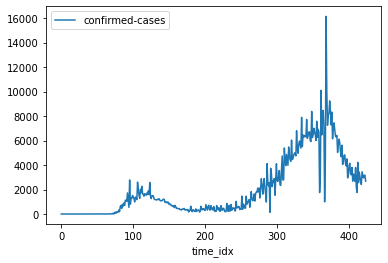

In [327]:
data[data.country=='Canada'].plot(x='time_idx', y='confirmed-cases')


<AxesSubplot:>

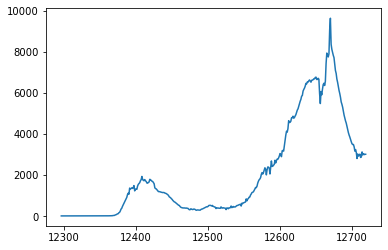

In [328]:
data[data.country=='Canada']['confirmed-cases'].rolling(7).mean().fillna(0).round().astype('int').plot()

In [329]:
for country in data.country.unique():
    data.loc[data.country == country, 'confirmed-cases'] =\
     data[data.country==country]['confirmed-cases'].rolling(7).\
                                                    mean().\
                                                    fillna(0).\
                                                    round().\
                                                    astype('int')

In [330]:
# Making measure comulatinve 
# Comulated days is sum_days

measures = [i for i in data.columns if 'comment' not in i and ("positive" in i or "negative" in i)]
sum_days = 25
for country in data.country.unique():
    data.loc[data.country == country, measures] =\
    data[data.country==country][measures].rolling(sum_days).sum().fillna(0).round().astype('int')


<AxesSubplot:xlabel='time_idx'>

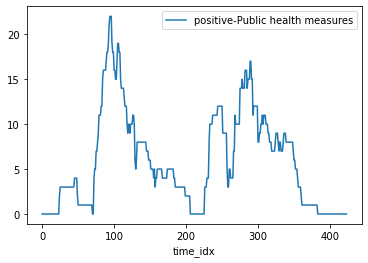

In [331]:
data[data.country=='Canada'].plot(x='time_idx', y=measures[0])


In [303]:
# Changing real values of measurements to zero and one categoris

def to_cat(x):
    
    x[x > 0] = "1"
    x[x == 0] = "0"
    
    return x


measures = [i for i in data.columns if 'comment' not in i and ("positive" in i or "negative" in i)]


data[measures] = data[measures].apply(to_cat).astype("category")



In [307]:
# Check if its working
i = 10
len(data[data[measures[i]] == "1"]) + len(data[data[measures[i]] == "0"]) == len(data)

Index(['time_idx', 'country', 'region', 'confirmed-cases',
       'positive-Public health measures', 'positive-Movement restrictions',
       'positive-Governance and socio-economic measures',
       'positive-Social distancing', 'positive-Lockdown',
       'positive-Humanitarian exemption',
       ...
       'negative-comment-embedding10', 'negative-comment-embedding11',
       'negative-comment-embedding12', 'negative-comment-embedding13',
       'negative-comment-embedding14', 'negative-comment-embedding15',
       'negative-comment-embedding16', 'negative-comment-embedding17',
       'negative-comment-embedding18', 'negative-comment-embedding19'],
      dtype='object', length=126)

In [332]:
# Removing countires with low number of new cases
avg_threshhold = 500

deleting_countries = []

for country in data.country.unique():
    case_avg = data[data.country == country]['confirmed-cases'].mean()
    if case_avg < avg_threshhold:
        deleting_countries.append(country)
        
print(f'Deleting {len(deleting_countries)} countries from {len(data.country.unique())} countries')

for country in deleting_countries:
    
    # Deleting those countries
    indices = data[data.country == country].index
    data = data.drop(indices)

Deleting 118 countries from 175 countries


In [166]:
# Remoivng all measures
# Removing negative and positive of the comments
# In the end just combined comments will remain

not_feature = ['time_idx', 'country', 'region', 'confirmed-cases']
comments = [i for i in data.columns if 'comment' in i]
com_names = [i[9:] for i in comments]
data_only_com = data[comments].T.groupby(com_names).sum().T
data_not_feature = data[not_feature].copy()
data_not_feature[com_names[:20]] = data_only_com[com_names[:20]]
# data = data_not_feature
# data
# data_not_feature

,time_idx,country,region,confirmed-cases,comment-embedding0,comment-embedding1,comment-embedding2,comment-embedding3,comment-embedding4,comment-embedding5,...,comment-embedding10,comment-embedding11,comment-embedding12,comment-embedding13,comment-embedding14,comment-embedding15,comment-embedding16,comment-embedding17,comment-embedding18,comment-embedding19
0,0,Argentina,Americas,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Argentina,Americas,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Argentina,Americas,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Argentina,Americas,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Argentina,Americas,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15683,419,United States,Americas,71562,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15684,420,United States,Americas,72230,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15685,421,United States,Americas,73376,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15686,422,United States,Americas,68612,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [311]:
comments = [i for i in data.columns if 'comment' in i]
not_feature = ['time_idx', 'country', 'region', 'confirmed-cases']
# data[not_feature + comments]
# data[comments]

In [333]:
data = data.reset_index()
data

,index,time_idx,country,region,confirmed-cases,positive-Public health measures,positive-Movement restrictions,positive-Governance and socio-economic measures,positive-Social distancing,positive-Lockdown,...,negative-comment-embedding10,negative-comment-embedding11,negative-comment-embedding12,negative-comment-embedding13,negative-comment-embedding14,negative-comment-embedding15,negative-comment-embedding16,negative-comment-embedding17,negative-comment-embedding18,negative-comment-embedding19
0,2120,0,Argentina,Americas,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2121,1,Argentina,Americas,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2122,2,Argentina,Americas,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2123,3,Argentina,Americas,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2124,4,Argentina,Americas,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24163,70803,419,United States,Americas,71562,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24164,70804,420,United States,Americas,72230,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24165,70805,421,United States,Americas,73376,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24166,70806,422,United States,Americas,68612,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [334]:
training_cutoff = data['time_idx'].max() - MAX_PREDICTION_LENGTH - 90


training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='confirmed-cases',
    group_ids=['country'],
    weight=None,
    min_prediction_idx = 30,
    min_encoder_length= MIN_ENCODER_LENGTH,
    max_encoder_length = MAX_ENCODER_LENGTH,
    min_prediction_length = MIN_PREDICTION_LENGTH,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    static_categoricals=['country', 'region'],
#     time_varying_unknown_categoricals = measures,
    time_varying_known_reals=['time_idx'],

    time_varying_unknown_reals = comments + measures + ['confirmed-cases'],     #
    
    target_normalizer=GroupNormalizer(
        groups=["country"], #transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

validation = TimeSeriesDataSet.from_dataset(
    training, 
    data[lambda x: x.time_idx <= training_cutoff + MAX_PREDICTION_LENGTH],
    predict=True, stop_randomization=True
)


In [335]:
train_dataloader = training.to_dataloader(
    train=True, 
    batch_size=BATCH_SIZE,
    num_workers=0                                     
)

val_dataloader = validation.to_dataloader(
    train=False,
    batch_size=BATCH_SIZE*10,
    num_workers=0
)

In [314]:
# x, y= next(iter(train_dataloader))
# x["decoder_target"].shape

In [336]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=False,
    mode='min'
)

lr_logger = LearningRateMonitor()
logger = TensorBoardLogger('lightning_logs')

### Finding Optimal Learning Rate

In [225]:
pl.seed_everything(RANDOM_SEED)
trainer = pl.Trainer(
    gpus = [0],
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=32,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=16,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 754
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 1921.8k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 464   
3  | prescalers                         | ModuleDict                      | 24.8 K
4  | static_variable_selection          | VariableSelectionNetwork        | 6.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_l

Restored states from the checkpoint file at /home/m25dehgh/testing_codes/stat/FP/DL-project/lr_find_temp_model.ckpt


suggested learning rate: 1.3182567385564071e-05


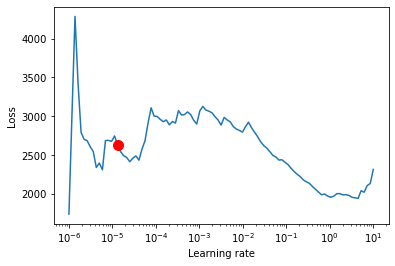

In [226]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [337]:
# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# create trainer
trainer = pl.Trainer(
    max_epochs=1000,
    gpus=[0],  # train on CPU, use gpus = [0] to run on GPU
    gradient_clip_val=0.1,
    weights_summary='top',
    limit_train_batches=30,  # running validation every 30 batches
    # fast_dev_run=True,  # comment in to quickly check for bugs
    callbacks=[lr_logger, early_stop_callback],
#     callbacks=[lr_logger],
    logger=logger,
)
# initialise model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=8e-04,
    hidden_size=32,  # biggest influence network size
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,  # QuantileLoss has 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # log example every 10 batches
    reduce_on_plateau_patience=4,  # reduce learning automatically
)
# tft.size() # 29.6k parameters in model
# # # fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 875   
3  | prescalers                         | ModuleDict                      | 4.1 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 6.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 302 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | Ga

/home/m25dehgh/anaconda3/envs/pyforecast/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

In [ ]:
!ls

In [341]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# best_tft

# trainer.fit(
#     best_tft,
#     train_dataloader=train_dataloader,
#     val_dataloaders=val_dataloader
# )
# type(best_tft)

In [342]:
# best_tft = tft
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(3001.1074)

In [343]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)


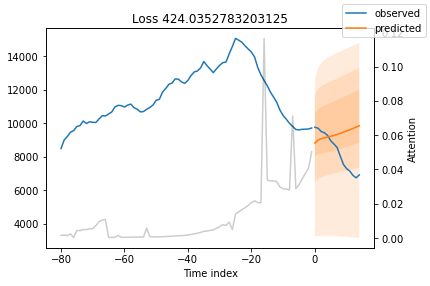

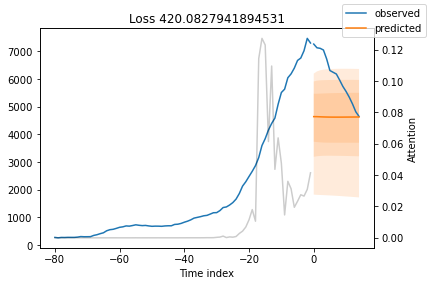

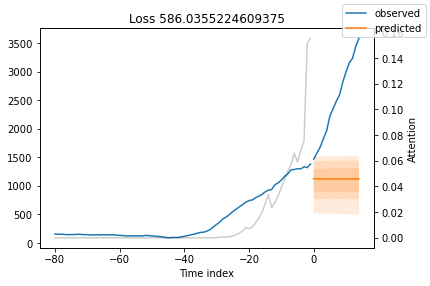

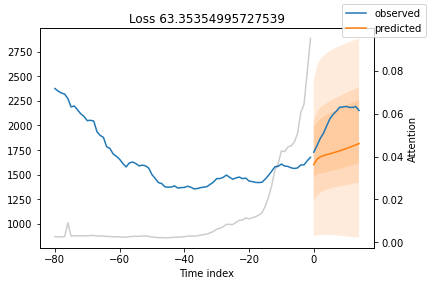

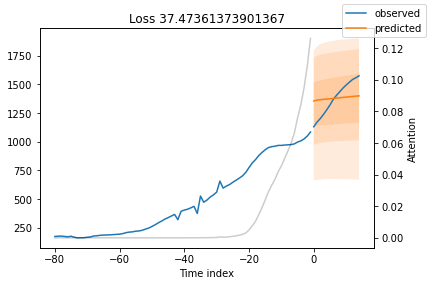

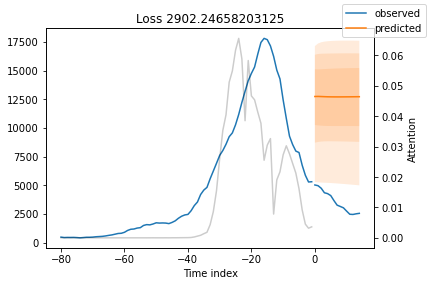

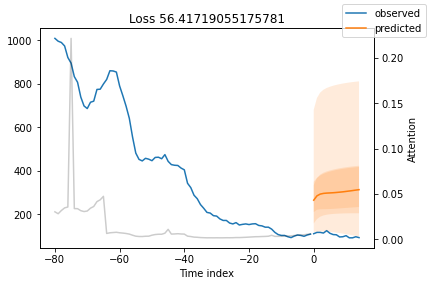

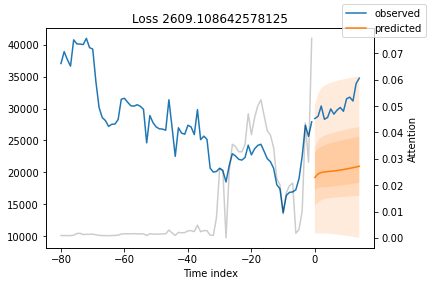

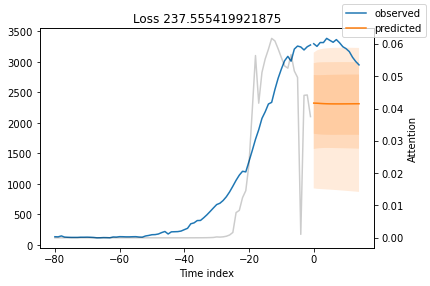

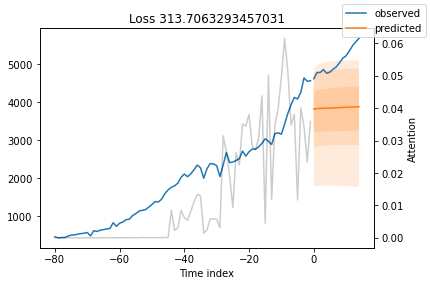

In [344]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);


In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)